# Physics 760: Computational Physics
## WS 2022/23
### Week 4
#### Pugazharasu Anancia Devaneyan, Rishi Kumar Senthil Kumar

In [25]:
#setup the notebook
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import random
import math as mth
import scipy as sp
from sympy import *
from scipy import special

Populating the interactive namespace from numpy and matplotlib


C:\Users\pugaz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Equations of Motion

In [53]:
def min_func(x,phi0,phi1,phi2):
    func = 0
    func = phi0 + (x*phi1) + ((x**2)*phi2)
    return func

In [39]:
def chi(phi0,phi1,phi2):
    f = [960,1025,1055,1085,1130]
    err_f = [25,20,15,10,8]
    x = [0.176,0.234,0.260,0.284,0.324]
    mass = 0
    for i in range(5):
        mass += ((f[i]-min_func(x[i],phi0,phi1,phi2))**2)/(err_f[i]**2)
    mass = mass/2
    return mass

In [37]:
def hammy(p0,p1,p2,phi0,phi1,phi2,beta):
    ham = 0
    ham = ((p0**2)/2) + ((p1**2)/2) + ((p2**2)/2) + (beta*chi(phi0,phi1,phi2))
    return ham

# Leapfrog Algorithm

In [63]:
def leap(p,phi,N_md):
    #Setting up the initial values
    p_out = np.array([1,2,3])
    phi_out = np.array([1,2,3])
    epsilon = 1/N_md
    f = [960,1025,1055,1085,1130]
    err_f = [25,20,15,10,8]
    x = [0.176,0.234,0.260,0.284,0.324]
    
    beta = 1000
    
    #Performing the first half step
    phi_out = phi_out + p*0.5*epsilon
    
    #Iterating through the Ṇ
    for i in range(N_md-1):
        for j in range(5):
            p_out[0] += -epsilon*beta*0.5*((2*min_func(x[j],phi_out[0],phi_out[1],phi_out[2]))-f[j])/err_f[j]
            p_out[1] += -epsilon*beta*0.5*(((1-(2*x[j]))*f[j])+(2*x[j]*min_func(x[j],phi_out[0],phi_out[1],phi_out[2])))/err_f[j]
            p_out[2] += -epsilon*beta*0.5*(((1-(2*(x[j]**2)))*f[j])+(2*(x[j]**2)*min_func(x[j],phi_out[0],phi_out[1],phi_out[2])))/err_f[j]
        phi_out += epsilon*p_out
        
    #Performing the final leap
    for k in range(5):
            p_out[0] += -epsilon*beta*0.5*((2*min_func(x[k],phi_out[0],phi_out[1],phi_out[2]))-f[k])/err_f[k]
            p_out[1] += -epsilon*beta*0.5*(((1-(2*x[k]))*f[k])+(2*x[k]*min_func(x[k],phi_out[0],phi_out[1],phi_out[2])))/err_f[k]
            p_out[2] += -epsilon*beta*0.5*(((1-(2*(x[k]**2)))*f[k])+(2*(x[k]**2)*min_func(x[k],phi_out[0],phi_out[1],phi_out[2])))/err_f[k] 
    phi_out += (epsilon/2)*p_out
    return phi,p

Now we plot for the convergence versus the number of steps taken

In [71]:
p_leap = np.array([np.random.normal(0,1),np.random.normal(0,1),np.random.normal(0,1)])
phi_leap = [80,800,600]
initial_hammy = hammy(p_leap[0],p_leap[1],p_leap[2],phi_leap[0],phi_leap[1],phi_leap[2],1000)

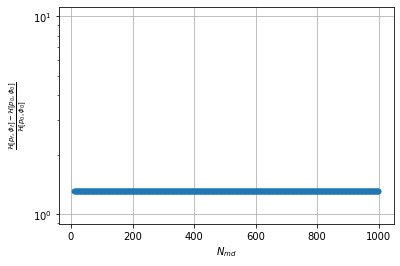

In [72]:
initial_hammy = hammy(p_leap[0],p_leap[1],p_leap[2],phi_leap[0],phi_leap[1],phi_leap[2],1000)
N_mds = np.arange(10,1000)
y_axis = []

for n in N_mds:
    new_q, new_p = leap(p_leap,phi_leap,n)
    final_hammy = hammy(new_q[0],new_q[1],new_q[2],new_p[0],new_p[1],new_p[2],1000) 
    y = (final_hammy-initial_hammy)/initial_hammy
    y_axis.append(y)

plt.plot(N_mds,y_axis,marker='.',markersize=9,linestyle='')
plt.yscale('log')
plt.xlabel('$N_{md}$')
plt.ylabel('$\\frac{\\mathcal{H}\\left[p_f, \\phi_f\\right]-\\mathcal{H}\\left[p_0, \\phi_0\\right]}{\\mathcal{H}\\left[p_0, \\phi_0\\right]}$')
plt.grid()
plt.savefig('Plots/h_v_n.png',dpi=300, bbox_inches = "tight")

# Hybrid Monte Carlo algorithm

In [66]:
def accept_reject(sweeps,phi,beta,N_md):
    phi_list = [[0,0,0]]
    phi_list.append(phi) 
    
    
    new_hammy = 0
    
    for i in range(sweeps):
        p_list = np.array([np.random.normal(0,1),np.random.normal(0,1),np.random.normal(0,1)])    
        #get last 3 elements of phi
        
        init_ham = hammy(p_list[0],p_list[1],p_list[2],phi_list[-1][0],phi_list[-1][1],phi_list[-1][2],beta)
        
        new_q,new_p = leap(p_list,phi_list[-1],N_md)
        
        new_hammy = hammy(new_p[0],new_p[1],new_p[2],new_q[0],new_q[1],new_q[2],beta)
        
        # fill in the metropolis critereon
        if np.random.uniform(0,1)<=np.exp(-(init_ham - new_hammy)):
            phi_list.append(new_q)
            
        else:
            phi_list.append(phi_list[-1])
        
    return phi_list

In [77]:
sweep_list = np.linspace(1,1000,1000,dtype = int)
phi_initial = [800,800,600]
field_list = [[0,0,0]]
var_1 = []
var_2 = []
var_3 = []
for s in sweep_list:
    field_list = accept_reject(s,phi_initial,1000,100)
    var_1.append(field_list[0])
    var_2.append(field_list[1])
    var_3.append(field_list[2])

KeyboardInterrupt: 

Let's try to find the best fit parameters now

In [ ]:
best_fit_params = []
best_fit_params_err = []

In [ ]:
best_fit_params[0] = var_1.mean()
best_fit_params_err[0] = var_1.std()

# Fitting to the data

In [16]:
f = [960,1025,1055,1085,1130]
f_err = [25,20,15,10,8]
m_data = [.176,0.234,0.260,0.284,0.324]

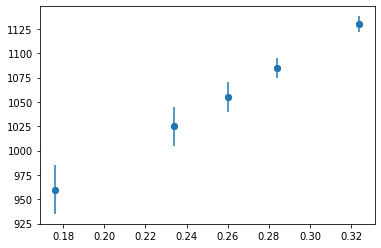

In [21]:
plt.scatter(m_data, f)
plt.errorbar(m_data, f, yerr=f_err, fmt="o")


plt.xlabel('$N_{md}$')
plt.ylabel('Acceptance rate')
plt.show()